In [55]:
import numpy as np
import matplotlib.pyplot as plt

In [56]:
class Particle:
    def __init__(self, coor, vel):
        self.coordinate = coor
        self.velocity = vel

In [97]:
class Environment:
    
    def __init__(self, d_max):
        self.D_max = d_max
        self.particles = []
        
    def generate_particles(self, N):
        for i in range(N):
            temp_coor = np.random.uniform(size=(2,))*self.D_max
            temp_vel = np.zeros((2,))
            particle = Particle(temp_coor, temp_vel)
            self.particles.append(particle)

    def show_environment(self):
        plt.figure(figsize=(10, 7))
        plt.xlim([0, self.D_max])
        plt.ylim([0, self.D_max])
        list_of_coors = []
        for p in self.particles: list_of_coors.append(p.coordinate)
        x,y = zip(*list_of_coors)
        plt.scatter(x, y, s=1000)

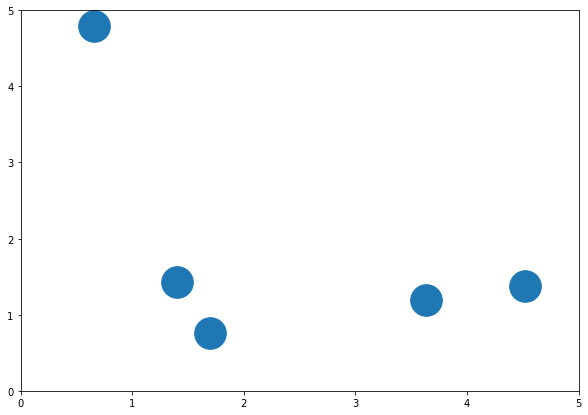

In [99]:
env = Environment(5)
env.generate_particles(5)
env.show_environment()